In [6]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !pip -q install gymnasium[mujoco]==1.0.0

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

# HW4: PPO (up to 5 points)


In this notebook you will be implementing Proximal Policy Optimization algorithm,
scaled up version of which was used to train [OpenAI Five](https://openai.com/blog/openai-five/)
to [win](https://openai.com/blog/how-to-train-your-openai-five/) against the
world champions in Dota 2.
You will be solving a continuous control environment on which it may be easier and faster
to train an agent, however note that PPO here may not be the best algorithm as, for example,
Soft Actor Critic may be more suited
for continuous control environments.

In [7]:
from tqdm import tqdm

In [8]:
import gymnasium as gym

ENV_NAME = "HalfCheetah-v5"


def make_env(**kwargs):
    return gym.make(ENV_NAME, **kwargs)


env = make_env(render_mode="rgb_array")
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(-inf, inf, (17,), float64)
Action space:  Box(-1.0, 1.0, (6,), float32)


In [9]:
import matplotlib.pyplot as plt

env.reset()
# plt.imshow(env.render())

(array([ 0.05687301,  0.07538615, -0.01472425,  0.04703867,  0.0420406 ,
         0.01068329,  0.0218032 , -0.0769422 , -0.0836568 , -0.03711308,
        -0.07539351, -0.13865677, -0.05830588,  0.20698676, -0.04888344,
        -0.25204886,  0.00734405]),
 {'x_position': np.float64(-0.013765831545113391)})

[Following 37 implementation details of PPO](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/#Andrychowicz), we apply all necessary wrappers to the environment. We also use a vectorized env to collect transitions in parallel.

In [10]:
from gymnasium.vector import AsyncVectorEnv
from gymnasium.wrappers.vector import (
    NormalizeObservation,
    NormalizeReward,
    ClipReward,
    RecordEpisodeStatistics,
)


def make_vec_env(num_envs, **kwargs):
    """Creates a vectorized Atari environment with preprocessing."""

    # Create a list of environment initialization functions
    env_fns = [lambda: make_env(**kwargs) for i in range(num_envs)]
    envs = AsyncVectorEnv(env_fns, shared_memory=True)
    envs = RecordEpisodeStatistics(envs, buffer_length=100000)

    # Use running statistics to scale observation
    # To have zero mean and unit std
    envs = NormalizeObservation(envs)

    # Use running std to scale reward
    envs = NormalizeReward(envs, gamma=0.99)

    # Clip reward after normalization
    envs = ClipReward(envs, min_reward=-10, max_reward=10)

    return envs


# Parameters
n_envs = 2  # Number of parallel environments
# Create the vectorized environment
vec_env = make_vec_env(n_envs)

Next, you will need to define a model for training. We suggest that you use two separate networks: one for policy
and another for value function. Each network should be a 3-layer MLP with 64 hidden units, $\mathrm{tanh}$
activation function.

Our policy distribution is going to be multivariate normal with diagonal covariance: $\mathcal{N}(\mu_\theta(s), diag (\sigma_\theta^2(s)))$
The network from above will predict the mean, and the covariance should be represented by a single
(learned) vector of size 6 (corresponding to the dimensionality of the action space from above). Or you can also predict the variance using your model. To construct a network akin to the one utilized in the test, the output vector should be twice the size of the action space. The first half of this vector should represent the mean of the actions, while the second half denotes the standard deviation of those actions. Additionally, apply the [softplus function](https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html) to the second half of the output vector to ensure the standard deviation values are positive.

Overall the model should return three things: predicted mean and variance of the distribution and value function.

In [11]:
# import tensorflow as tf
import torch

from torch import nn
from torch.nn import functional as F
import torch


class PolicyModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.h = 64

        self.policy_model = nn.Sequential(
            nn.Linear(state_dim, self.h),
            nn.Tanh(),
            nn.Linear(self.h, self.h),
            nn.Tanh(),
            nn.Linear(self.h, 2 * action_dim)
        )

        self.value_model = nn.Sequential(
            nn.Linear(state_dim, self.h),
            nn.Tanh(),
            nn.Linear(self.h, self.h),
            nn.Tanh(),
            nn.Linear(self.h, 1)
        )

    def get_policy(self, x):
        output = self.policy_model(x)
        mean, std_raw = output.chunk(2, dim=-1)
        var = F.softplus(std_raw)
        return mean, var

    def get_value(self, x):
        out = self.value_model(x)
        return out

    def forward(self, x):
        policy = self.get_policy(x)
        value = self.get_value(x)
        return policy, value

This model will be wrapped by a `Policy`. The policy can work in two modes, but in either case
it is going to return dictionary with string-type keys. The first mode is when the policy is
used to sample actions for a trajectory which will later be used for training. In this case
the flag `training` passed to `act` method is `False` and the method should return
a `dict` with the following keys:

* `"actions"`: sampled actions to pass to the environment
* `"log_probs"`: log-probabilities of sampled actions
* `"values"`: value function $V^\pi(s)$ predictions.

We don't need to use the values under these keys for training, so all of them should be of type `np.ndarray`.

When `training` is `True`, the model is training on a given batch of observations. In this
case it should return a `dict` with the following keys

* `"distribution"`: an instance of multivariate normal distribution (`torch.distributions.MultivariateNormal`)
* `"values"`: value function $V^\pi(s)$ prediction.

The distinction about the modes comes into play depending on where the policy is used: if it is called from `EnvRunner`,
the `training` flag is `False`, if it is called from `PPO`, the `training` flag is `True`. These classes
will be described below.

In [12]:
from torch.distributions.multivariate_normal import MultivariateNormal


class Policy:
    def __init__(self, model):
        self.model = model

    def act(self, inputs, training=False):
        inputs = torch.tensor(inputs, dtype=torch.float32, device="cuda")

        (mean, var), values = self.model(inputs)
        cov_matrix = torch.diag_embed(var.pow(2))
        normal_distr = MultivariateNormal(mean, cov_matrix)

        actions = normal_distr.sample()
        log_probs = normal_distr.log_prob(actions)

        if training:
            return {"distribution": normal_distr, "values": values.squeeze()}

        return {
            "actions": actions.cpu().numpy().squeeze(),
            "log_probs": log_probs.detach().cpu().numpy().squeeze(),
            "values": values.detach().cpu().numpy().squeeze(),
        }

We will use `EnvRunner` to perform interactions with an environment with a policy for a fixed number of timesteps. Calling `.get_next()` on a runner will return a trajectory &mdash; dictionary
containing keys

* `"observations"`
* `"rewards"`
* `"resets"`
* `"actions"`
* all other keys that you defined in `Policy`,

under each of these keys there is a `np.ndarray` of specified length $T$ &mdash; the size of partial trajectory.

Additionally, before returning a trajectory this runner can apply a list of transformations.
Each transformation is simply a callable that should modify passed trajectory in-place.

In [13]:
class AsArray:
    """
    Converts lists of interactions to ndarray.
    """

    def __call__(self, trajectory):
        # Modify trajectory inplace.
        for k, v in filter(lambda kv: kv[0] != "state", trajectory.items()):
            trajectory[k] = np.asarray(v)

In [14]:
""" RL env runner """

from collections import defaultdict

import numpy as np


class EnvRunner:
    """Reinforcement learning runner in an environment with given policy"""

    def __init__(self, env, policy, rollout_length, transforms=None, step_var=None):
        self.env = env
        self.policy = policy
        self.rollout_length = rollout_length
        self.transforms = transforms or []
        self.step_var = step_var if step_var is not None else 0
        self.state = {"latest_observation": self.env.reset()[0]}

    @property
    def num_envs(self):
        """Returns number of batched envs or `None` if env is not batched"""
        return getattr(self.env, "num_envs", None)

    def reset(self, **kwargs):
        """Resets env and runner states."""
        self.state["latest_observation"], info = self.env.reset(**kwargs)
        self.policy.reset()

    def get_next(self):
        """Runs the agent in the environment."""
        trajectory = defaultdict(list, {"actions": []})
        observations = []
        rewards = []
        resets = []
        self.state["env_steps"] = self.rollout_length

        for i in range(self.rollout_length):
            observations.append(self.state["latest_observation"])
            act = self.policy.act(self.state["latest_observation"])
            if "actions" not in act:
                raise ValueError(
                    "result of policy.act must contain 'actions' "
                    f"but has keys {list(act.keys())}"
                )
            for key, val in act.items():
                trajectory[key].append(val)

            obs, rew, terminated, truncated, _ = self.env.step(
                trajectory["actions"][-1]
            )
            done = np.logical_or(terminated, truncated)
            self.state["latest_observation"] = obs
            rewards.append(rew)
            resets.append(done)
            self.step_var += self.num_envs or 1

            # Only reset if the env is not batched. Batched envs should
            # auto-reset.
            if not self.num_envs and np.all(done):
                self.state["env_steps"] = i + 1
                self.state["latest_observation"] = self.env.reset()[0]

        trajectory.update(observations=observations, rewards=rewards, resets=resets)
        trajectory["state"] = self.state

        for transform in self.transforms:
            transform(trajectory)
        return trajectory

In [15]:
import numpy as np


class DummyPolicy:
    def act(self, inputs, training=False):
        num_envs = inputs.shape[0]
        assert not training
        return {"actions": np.random.randn(num_envs, 6), "values": [np.nan] * num_envs}


runner = EnvRunner(vec_env, DummyPolicy(), 3, transforms=[AsArray()])
trajectory = runner.get_next()

{k: v.shape for k, v in trajectory.items() if k != "state"}

{'actions': (3, 2, 6),
 'values': (3, 2),
 'observations': (3, 2, 17),
 'rewards': (3, 2),
 'resets': (3, 2)}

You will need to implement the following two transformations.

The first is `GAE` that implements [Generalized Advantage Estimator](https://arxiv.org/abs/1506.02438).
You should add two keys to the trajectory: `"advantages"` and `"value_targets"`. In GAE the advantages
$A_t^{\mathrm{GAE}(\gamma,\lambda)}$ are essentially defined as the exponential
moving average with parameter $\lambda$ of the regular advantages
$\hat{A}^{(T)}(s_t) = \sum_{l=0}^{T-t-1} \gamma^l r_{t+l} + \gamma^{T} V^\pi(s_{T}) - V^\pi(s_t)$.
The exact formula for the computation is the following

$$
A_{t}^{\mathrm{GAE}(\gamma,\lambda)} = \sum_{l=0}^{T-t-1} (\gamma\lambda)^l\delta_{t + l}^V, \, t \in [0, T)
$$
where $\delta_{t+l}^V = r_{t+l} + \gamma V^\pi(s_{t+l+1}) - V^\pi(s_{t+l})$. You can look at the
derivation (formulas 11-16) in the paper. Don't forget to reset the summation on terminal
states as determined by the flags `trajectory["resets"]`. You can use `trajectory["values"]`
to get values of all observations except the most recent which is stored under
 `trajectory["state"]["latest_observation"]`. For this observation you will need to call the policy
 to get the value prediction.

Once you computed the advantages, you can get the targets for training the value function by adding
back values:
$$
\hat{V}(s_{t}) = A_{t}^{\mathrm{GAE}(\gamma,\lambda)} + V(s_{t}),
$$
where $\hat{V}$ is a tensor of value targets that are used to train the value function.

In [16]:
class GAE:
    """Generalized Advantage Estimator."""

    def __init__(self, policy, gamma=0.99, lambda_=0.95):
        self.policy = policy
        self.gamma = gamma
        self.lambda_ = lambda_

    def __call__(self, trajectory):
        gamma = self.gamma
        lambda_ = self.lambda_

        latest_obs = trajectory["state"]["latest_observation"]
        
        if latest_obs.ndim == 1:
            latest_obs_batch = np.expand_dims(latest_obs, axis=0)
        else:
            latest_obs_batch = latest_obs
        
        last_value_prediction = self.policy.act(latest_obs_batch, training=False)["values"]
        
        if last_value_prediction.ndim == 0: # Scalar case
            last_value_prediction = np.array([[last_value_prediction]])
        elif last_value_prediction.ndim == 1: # (num_envs,) case
            last_value_prediction = np.expand_dims(last_value_prediction, axis=0)
        
        all_values = np.concatenate([trajectory["values"], last_value_prediction], axis=0)
        rewards = trajectory["rewards"]
        resets = trajectory["resets"]

        if rewards.ndim == 1:
            rewards = rewards[:, np.newaxis] # Reshape to (rollout_length, 1)
        if resets.ndim == 1:
            resets = resets[:, np.newaxis]
        
        rollout_length = rewards.shape[0]
        num_envs = rewards.shape[1]
        advantages = np.zeros_like(rewards, dtype=np.float32)
        last_gae_advantage = np.zeros(num_envs, dtype=np.float32)

        for t in reversed(range(rollout_length)):
            delta = rewards[t] + gamma * all_values[t + 1] * (1 - resets[t]) - all_values[t]
            advantages[t] = delta + gamma * lambda_ * last_gae_advantage * (1 - resets[t])
            last_gae_advantage = advantages[t]

        value_targets = advantages + all_values[:-1]
        
        trajectory["advantages"] = advantages
        trajectory["value_targets"] = value_targets

**Test GAE**

In [17]:
!curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/actions.npy
!curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/log_probs.npy
!curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/values.npy
!curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/observations.npy
!curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/rewards.npy
!curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/resets.npy
!curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/state.npy
!curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/advantages.npy
!curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/value_targets.npy
!curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/policy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 98432  100 98432    0     0   214k      0 --:--:-- --:--:-- --:--:--  214k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8320  100  8320    0     0  25794      0 --:--:-- --:--:-- --:--:-- 25838
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8320  100  8320    0     0  19310      0 --:--:-- --:--:-- --:--:-- 19303
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  272k  100  272k    0     0   647k      0 --:--:-- --:--:-- --:--:--  647k
  % Total    % Received % Xferd  Average Speed   Tim

In [18]:
def test_gae():
    trajectory = {}
    for key in ["actions", "log_probs", "values", "observations", "rewards", "resets"]:
        trajectory[key] = np.load(f"{key}.npy", allow_pickle=True)
    trajectory["state"] = {"latest_observation": np.array([np.load("state.npy")])}

    policy = torch.load(f"policy", weights_only=False)
    policy.model = policy.model.cuda()
    gae_to_test = GAE(policy, gamma=0.99, lambda_=0.95)

    gae_to_test(trajectory)

    for key in ["advantages", "value_targets"]:
        expected = np.load(f"{key}.npy")
        generated = trajectory[key]
        assert np.allclose(expected.ravel(), generated.ravel(), atol=2e-2), key

    print("All passed")


test_gae()

All passed


The main advantage of PPO over simpler policy based methods like A2C is that it is possible
to train on the same trajectory for multiple gradient steps. The following class wraps
an `EnvRunner`. It should call the runner to get a trajectory, then return minibatches
from it for a number of epochs, shuffling the data before each epoch.

In [19]:
def flatten_first_two_dims(arr):
    if arr.ndim == 2:
        return arr.reshape(-1)
    return arr.reshape(arr.shape[0] * arr.shape[1], *arr.shape[2:])


class TrajectorySampler:
    """Samples minibatches from trajectory for a number of epochs."""

    def __init__(self, runner, num_epochs, num_minibatches, transforms=None):
        self.runner = runner
        self.num_epochs = num_epochs
        self.num_minibatches = num_minibatches
        self.transforms = transforms or []
        self.minibatch_count = 0
        self.epoch_count = 0
        self.trajectory = None

    def shuffle_trajectory(self):
        """Shuffles all elements in trajectory.

        Should be called at the beginning of each epoch.
        """
        trajectory_len = len(self.trajectory["observations"])

        permutation = np.random.permutation(trajectory_len)
        for key, value in self.trajectory.items():
            if key != "state":
                self.trajectory[key] = value[permutation]

    def squeeze_trajectory(self):
        for key, value in self.trajectory.items():
            if key != "state":
                self.trajectory[key] = flatten_first_two_dims(value)

    def get_trajectory(self):
        self.trajectory = self.runner.get_next()
        self.squeeze_trajectory()

    def get_next(self):
        """Returns next minibatch."""
        if not self.trajectory:
            self.get_trajectory()

        if self.minibatch_count == self.num_minibatches:
            self.shuffle_trajectory()
            self.minibatch_count = 0
            self.epoch_count += 1

        if self.epoch_count == self.num_epochs:
            self.get_trajectory()
            self.shuffle_trajectory()
            self.minibatch_count = 0
            self.epoch_count = 0

        trajectory_len = self.trajectory["observations"].shape[0]

        batch_size = trajectory_len // self.num_minibatches

        minibatch = {}
        for key, value in self.trajectory.items():
            if key != "state":
                minibatch[key] = value[
                    self.minibatch_count
                    * batch_size : (self.minibatch_count + 1)
                    * batch_size
                ]

        self.minibatch_count += 1

        for transform in self.transforms:
            transform(minibatch)

        return minibatch

A common trick to use with GAE is to normalize advantages, please implement the normalization.

In [20]:
class NormalizeAdvantages:
    """Normalizes advantages to have zero mean and unit std."""

    def __call__(self, trajectory):
        advantages = trajectory["advantages"]
        mean = np.mean(advantages)
        std = np.std(advantages) + np.finfo(advantages.dtype).eps
        trajectory["advantages"] = (advantages - mean) / std

Finally, we can create our PPO sampler.

In [21]:
def make_ppo_sampler(
    env,
    policy,
    num_runner_steps=2048,
    gamma=0.99,
    lambda_=0.95,
    num_epochs=10,
    num_minibatches=32,
):
    """Creates runner for PPO algorithm."""
    runner_transforms = [AsArray(), GAE(policy, gamma=gamma, lambda_=lambda_)]
    runner = EnvRunner(env, policy, num_runner_steps, transforms=runner_transforms)

    sampler_transforms = [NormalizeAdvantages()]
    sampler = TrajectorySampler(
        runner,
        num_epochs=num_epochs,
        num_minibatches=num_minibatches,
        transforms=sampler_transforms,
    )
    return sampler

In the next cell you will need to implement Proximal Policy Optimization algorithm itself. The algorithm
modifies the typical policy gradient loss in the following way:

$$
J_{\pi}(s, a) = \frac{\pi_\theta(a|s)}{\pi_\theta^{\text{old}}(a|s)} \cdot A^{\mathrm{GAE}(\gamma,\lambda)}(s, a)
$$

$$
J_{\pi}^{\text{clipped}}(s, a) = \mathrm{clip}\left(
\frac{\pi_\theta(a|s)}{\pi_{\theta^{\text{old}}}(a|s)},
1 - \text{cliprange}, 1 + \text{cliprange}\right)\cdot A^{\mathrm{GAE(\gamma, \lambda)}}(s, a)\\
$$

$$
L_{\text{policy}} = -\frac{1}{T}\sum_{t=0}^{T-1}\min\left(J_\pi(s_{t}, a_{t}), J_{\pi}^{\text{clipped}}(s_{t}, a_{t})\right).
$$

The value loss is also modified:

$$
L_{V}^{\text{clipped}} = \frac{1}{T}\sum_{t=0}^{T-1} \max(l^{simple}(s_{t}), l^{clipped}(s_{t}))
$$
, where $l^{simple}$ is your standard critic loss
$$
l^{simple}(s_{t}) = [V_\theta(s_{t}) - \hat{V}(s_{t})]^2
$$

and $l^{clipped}$ is a clipped version that limits large changes of the value function:
$$
l^{clipped}(s_{t}) = [
V_{\theta^{\text{old}}}(s_{t}) +
\text{clip}\left(
V_\theta(s_{t}) - V_{\theta^\text{old}}(s_{t}),
-\text{cliprange}, \text{cliprange}
\right) - \hat{V}(s_{t})] ^ 2
$$

In [22]:
class PPO:
    def __init__(
        self, policy, optimizer, cliprange=0.2, value_loss_coef=0.25, max_grad_norm=0.5
    ):
        self.policy = policy
        self.optimizer = optimizer
        self.cliprange = cliprange
        self.value_loss_coef = value_loss_coef
        # Note that we don't need entropy regularization for this env.
        self.max_grad_norm = max_grad_norm
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def policy_loss(self, trajectory, act):
        """Computes and returns policy loss on a given trajectory."""
        current_distribution = act["distribution"]
        current_values = act["values"]
        old_log_probs = torch.tensor(trajectory["log_probs"], dtype=torch.float32, device=self.device)
        advantages = torch.tensor(trajectory["advantages"], dtype=torch.float32, device=self.device)
        old_actions = torch.tensor(trajectory["actions"], dtype=torch.float32, device=self.device)
        log_probs = current_distribution.log_prob(old_actions)
        ratio = torch.exp(log_probs - old_log_probs)
        j_pi = ratio * advantages
        j_pi_clipped = torch.clamp(ratio, 1 - self.cliprange, 1 + self.cliprange) * advantages
        policy_loss = -torch.mean(torch.min(j_pi, j_pi_clipped))
        return policy_loss

    def value_loss(self, trajectory, act):
        """Computes and returns value loss on a given trajectory."""
        current_values = act["values"]
        value_targets = torch.tensor(trajectory["value_targets"], dtype=torch.float32, device=self.device)
        old_values = torch.tensor(trajectory["values"], dtype=torch.float32, device=self.device)
        l_simple = (current_values - value_targets).pow(2)
        value_diff = current_values - old_values
        clipped_value_diff = torch.clamp(value_diff, -self.cliprange, self.cliprange)
        l_clipped = (old_values + clipped_value_diff - value_targets).pow(2)
        value_loss = torch.mean(torch.max(l_simple, l_clipped))
        return value_loss

    def loss(self, trajectory):
        observations = torch.tensor(trajectory["observations"], dtype=torch.float32, device=self.device)
        act = self.policy.act(observations, training=True)
        p_loss = self.policy_loss(trajectory, act)
        v_loss = self.value_loss(trajectory, act)
        total_loss = p_loss + self.value_loss_coef * v_loss
        return total_loss, p_loss, v_loss

    def step(self, trajectory):
        """Computes the loss function and performs a single gradient step."""
        self.optimizer.zero_grad()
        total_loss, p_loss, v_loss = self.loss(trajectory)
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.policy.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
        return {
            "total_loss": total_loss.item(),
            "policy_loss": p_loss.item(),
            "value_loss": v_loss.item(),
        }

Now everything is ready to do training. In one million of interactions it should be possible to
achieve the total raw reward of about 1500. You should plot this quantity with respect to
`runner.step_var` &mdash; the number of interactions with the environment. It is highly
encouraged to also provide plots of the following quantities (these are useful for debugging as well):

* [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) between
value targets and value predictions
* Entropy of the policy $\pi$
* Value loss
* Policy loss
* Value targets
* Value predictions
* Gradient norm
* Advantages

For optimization it is suggested to use Adam optimizer with linearly annealing learning rate
from 3e-4 to 0 and epsilon 1e-5.

In [23]:
state_dim = vec_env.single_observation_space.shape[0]
action_dim = vec_env.single_action_space.shape[0]

model = PolicyModel(state_dim, action_dim)
model = model.cuda()

policy = Policy(model)

num_envs = 20
vec_env = make_vec_env(num_envs=num_envs)
sampler = make_ppo_sampler(vec_env, policy)

optimizer = torch.optim.Adam(policy.model.parameters(), lr=3e-4, eps=1e-5)
n_iter = 250000

lr_mult = lambda epoch: (1 - (epoch / n_iter))
sched = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_mult)

ppo = PPO(policy, optimizer)

In [24]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

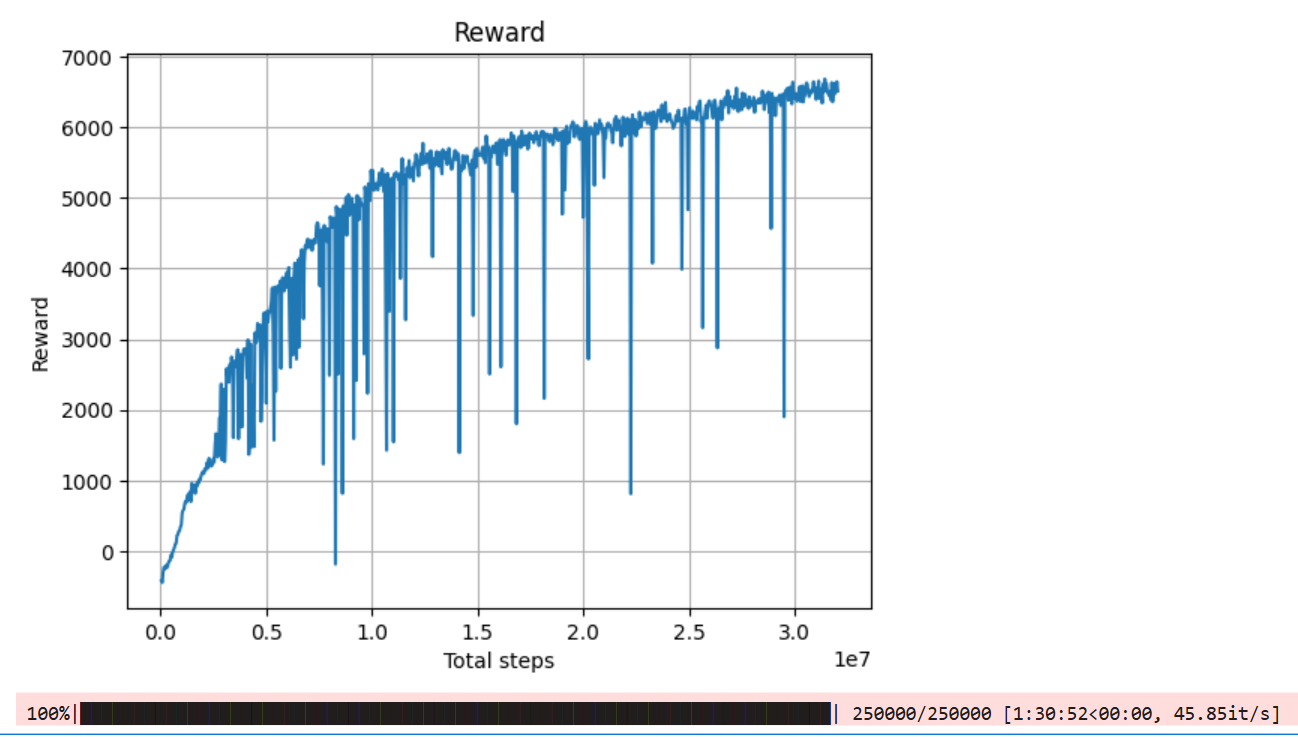

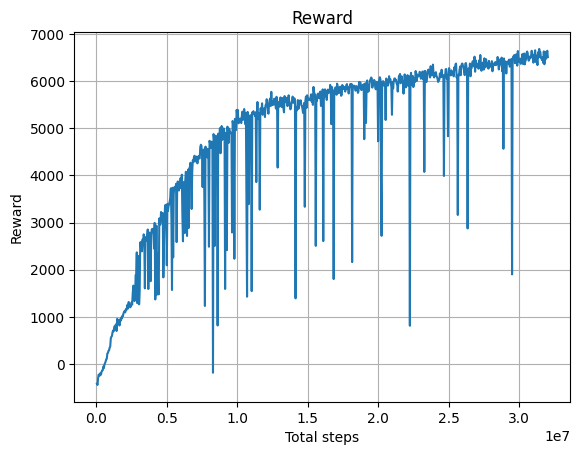

100%|██████████████████████████████████████████████████████████████████████| 250000/250000 [1:30:52<00:00, 45.85it/s]


In [20]:
steps = []
rewards = []

for i in tqdm(range(n_iter)):
    trajectory = sampler.get_next()

    if (i + 1) % 100 == 0:
        clear_output(True)
        rewards.append(vec_env.env.env.env.return_queue[-1])
        steps.append(sampler.runner.step_var)
        
        plt.plot(steps, rewards, label="episode rewards")
        plt.title("Reward")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()
        plt.show()

    ppo.step(trajectory)
    sched.step()

## Evaluation

In [25]:
from typing import Any, Tuple, Optional

def evaluate(
    env: gym.Env, 
    actor: Any, 
    n_games: int = 1, 
    t_max: int = 1000
) -> Tuple[float, float]:

    rewards: List[float] = []
    
    for _ in range(n_games):
        observation, _ = env.reset()
        episode_reward = 0.0
        
        for _ in range(t_max):
            if isinstance(observation, np.ndarray) and observation.ndim == 1:
                observation_batch = np.array([observation])
            else:
                observation_batch = observation

            action_dict = actor.act(observation_batch, training=False)
            action = action_dict["actions"]

            if (isinstance(action, np.ndarray) and action.ndim > 1 and 
                getattr(env.unwrapped, "num_envs", None) is None):
                action = action[0]

            observation, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            
            if terminated or truncated:
                break
                
        rewards.append(episode_reward)
    
    return np.mean(rewards), np.std(rewards)

In [32]:
def evaluate_model_without_rendering(
    policy: Any, 
    env_id: str,
    vec_env_normalizer: Optional[Any] = None,
    num_episodes: int = 5,
    max_steps: int = 1000
) -> None:

    test_env = gym.make(env_id)
    
    if vec_env_normalizer is not None:
        test_env = gym.wrappers.NormalizeObservation(test_env)
        test_env.obs_rms = vec_env_normalizer

    mean_reward, std_reward = evaluate(test_env, policy, n_games=num_episodes, t_max=max_steps)

    print(f"Оценка модели на {num_episodes} эпизодах:")
    print(f"Средняя награда: {mean_reward:.2f} ± {std_reward:.2f}")

    test_env.close()

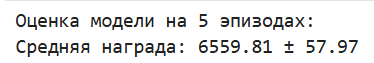

In [27]:
evaluate_model_without_rendering(
    policy=policy,
    env_id="HalfCheetah-v5",
    vec_env_normalizer=vec_env.env.env.obs_rms,
    num_episodes=5,
    max_steps=1000
)

Оценка модели на 5 эпизодах:
Средняя награда: 6559.81 ± 57.97


# Bonus area
* Implement Recurrent PPO using LSTM and compare it with vanilla MLP PPO. (up to 3 points) See: https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details

## RecurrentPolicyModel

In [170]:
def layer_init(layer: nn.Module, std: float = np.sqrt(2), bias_const: float = 0.0) -> nn.Module:
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class RecurrentPolicyModel(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_size: int = 64, lstm_hidden_size: int = 64):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm_hidden_size = lstm_hidden_size
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.feature_extractor = nn.Sequential(
            layer_init(nn.Linear(state_dim, self.hidden_size)),
            nn.Tanh(),
            layer_init(nn.Linear(self.hidden_size, self.hidden_size)),
            nn.Tanh(),
        )
        
        self.lstm = nn.LSTM(self.hidden_size, self.lstm_hidden_size)
        self._init_lstm_weights()
        
        self.actor_head = layer_init(nn.Linear(self.lstm_hidden_size, 2 * action_dim), std=0.01)
        self.critic_head = layer_init(nn.Linear(self.lstm_hidden_size, 1), std=1.0)

    def _init_lstm_weights(self) -> None:
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                nn.init.constant_(param, 0)
            elif "weight" in name:
                nn.init.orthogonal_(param, 1.0)

    def get_states(self, x: torch.Tensor, lstm_state: Tuple[torch.Tensor, torch.Tensor], 
                   done: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        features = self.feature_extractor(x)
        batch_size = features.shape[0]
        
        features = features.unsqueeze(0)
        
        h_state, c_state = lstm_state
        
        if h_state.shape != (1, batch_size, self.lstm_hidden_size):
            h_state = h_state.view(1, batch_size, self.lstm_hidden_size)
        if c_state.shape != (1, batch_size, self.lstm_hidden_size):
            c_state = c_state.view(1, batch_size, self.lstm_hidden_size)
        
        done_mask = (1.0 - done).view(1, batch_size, 1)
        reset_lstm_state = (
            done_mask * h_state,
            done_mask * c_state
        )
        
        output, new_lstm_state = self.lstm(features, reset_lstm_state)
        hidden = output.squeeze(0)
        
        return hidden, new_lstm_state

    def forward(self, x: torch.Tensor, lstm_state: Tuple[torch.Tensor, torch.Tensor], 
                done: torch.Tensor) -> Tuple[Tuple[torch.Tensor, torch.Tensor], torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        hidden, new_lstm_state = self.get_states(x, lstm_state, done)
        
        policy_output = self.actor_head(hidden)
        mean, std_raw = policy_output.chunk(2, dim=-1)
        var = F.softplus(std_raw) + 1e-8
        
        value = self.critic_head(hidden)
        
        return (mean, var), value, new_lstm_state

    def init_hidden_state(self, batch_size: int, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        h0 = torch.zeros(1, batch_size, self.lstm_hidden_size, device=device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_size, device=device)
        return (h0, c0)

## RecurrentPolicy

In [171]:
class RecurrentPolicy:
    def __init__(self, model: torch.nn.Module, device: Optional[torch.device] = None) -> None:
        self.model = model
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self._lstm_state: Optional[Tuple[torch.Tensor, torch.Tensor]] = None
        self._batch_size: int = 1
        
    def reset(self, batch_size: int = 1) -> None:
        self._batch_size = batch_size
        self._lstm_state = self.model.init_hidden_state(batch_size, self.device)
        
    def _ensure_lstm_state(self, batch_size: int) -> None:
        if self._lstm_state is None or self._lstm_state[0].shape[1] != batch_size:
            self.reset(batch_size)
    
    def act(
        self, 
        inputs: Union[torch.Tensor, np.ndarray], 
        lstm_state: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
        done: Optional[Union[torch.Tensor, np.ndarray, bool]] = None,
        training: bool = False
    ) -> Dict[str, Any]:
        inputs = self._prepare_tensor(inputs)
        batch_size = inputs.shape[0]
        
        if lstm_state is None:
            self._ensure_lstm_state(batch_size)
            lstm_state = self._lstm_state
            
        if done is None:
            done = torch.zeros(batch_size, dtype=torch.float32, device=self.device)
        else:
            done = self._prepare_done_tensor(done, batch_size)
        
        with torch.set_grad_enabled(training):
            (mean, var), values, new_lstm_state = self.model(inputs, lstm_state, done)
            
        self._lstm_state = new_lstm_state
        
        distribution = self._create_distribution(mean, var)
        actions = distribution.sample()
        log_probs = distribution.log_prob(actions)
        
        if training:
            return {
                "distribution": distribution,
                "values": values.squeeze(-1),
                "lstm_state": new_lstm_state,
                "actions": actions,
                "log_probs": log_probs
            }
        
        return {
            "actions": self._to_numpy(actions),
            "log_probs": self._to_numpy(log_probs),
            "values": self._to_numpy(values.squeeze(-1)),
            "lstm_state": new_lstm_state
        }
    
    def evaluate_actions(
        self,
        inputs: torch.Tensor,
        actions: torch.Tensor,
        lstm_states: Tuple[torch.Tensor, torch.Tensor],
        dones: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        (mean, var), values, new_lstm_state = self.model(inputs, lstm_states, dones)
        distribution = self._create_distribution(mean, var)
        
        log_probs = distribution.log_prob(actions)
        entropy = distribution.entropy()
        
        return log_probs, entropy, values.squeeze(-1), new_lstm_state
    
    def _prepare_tensor(self, data: Union[torch.Tensor, np.ndarray]) -> torch.Tensor:
        if isinstance(data, np.ndarray):
            data = torch.from_numpy(data)
        if data.ndim == 1:
            data = data.unsqueeze(0)
        return data.float().to(self.device)
    
    def _prepare_done_tensor(self, done: Union[torch.Tensor, np.ndarray, bool], batch_size: int) -> torch.Tensor:
        if isinstance(done, bool):
            done = torch.full((batch_size,), done, dtype=torch.float32, device=self.device)
        elif isinstance(done, np.ndarray):
            done = torch.from_numpy(done).float().to(self.device)
        else:
            done = done.float().to(self.device)
        
        if done.ndim == 0:
            done = done.unsqueeze(0)
        return done
    
    def _create_distribution(self, mean: torch.Tensor, var: torch.Tensor) -> MultivariateNormal:
        cov_matrix = torch.diag_embed(var.clamp(min=1e-8))
        return MultivariateNormal(mean, cov_matrix)
    
    def _to_numpy(self, tensor: torch.Tensor) -> np.ndarray:
        return tensor.detach().cpu().numpy()

## RecurrentEnvRunner

In [172]:
class RecurrentEnvRunner:
    def __init__(self, env, policy, rollout_length: int, transforms: Optional[List] = None, step_var: Optional[int] = None):
        self.env = env
        self.policy = policy
        self.rollout_length = rollout_length
        self.transforms = transforms or []
        self.step_var = step_var if step_var is not None else 0
        self.state = {"latest_observation": self.env.reset()[0]}
        self._initialize_policy()
        
    def _initialize_policy(self) -> None:
        batch_size = self.num_envs or 1
        self.policy.reset(batch_size)
        
    @property
    def num_envs(self) -> Optional[int]:
        return getattr(self.env, "num_envs", None)

    def reset(self, **kwargs) -> None:
        self.state["latest_observation"], info = self.env.reset(**kwargs)
        batch_size = self.num_envs or 1
        self.policy.reset(batch_size)

    def get_next(self) -> Dict[str, Any]:
        trajectory = defaultdict(list)
        observations = []
        rewards = []
        resets = []
        lstm_states_h = []
        lstm_states_c = []
        
        self.state["env_steps"] = self.rollout_length
        batch_size = self.num_envs or 1
        lstm_hidden_size = self.policy.model.lstm_hidden_size

        for i in range(self.rollout_length):
            observations.append(self.state["latest_observation"])
            
            current_lstm_state = self.policy._lstm_state
            h_state = current_lstm_state[0].squeeze(0).detach().cpu().numpy()
            c_state = current_lstm_state[1].squeeze(0).detach().cpu().numpy()
            
            if h_state.shape != (batch_size, lstm_hidden_size):
                h_state = h_state[:batch_size, :lstm_hidden_size]
            if c_state.shape != (batch_size, lstm_hidden_size):
                c_state = c_state[:batch_size, :lstm_hidden_size]
            
            lstm_states_h.append(h_state)
            lstm_states_c.append(c_state)
            
            act = self.policy.act(self.state["latest_observation"])
            if "actions" not in act:
                raise ValueError(
                    f"result of policy.act must contain 'actions' but has keys {list(act.keys())}"
                )
            
            for key, val in act.items():
                if key != "lstm_state":
                    trajectory[key].append(val)

            obs, rew, terminated, truncated, _ = self.env.step(trajectory["actions"][-1])
            done = np.logical_or(terminated, truncated)
            
            self.state["latest_observation"] = obs
            rewards.append(rew)
            resets.append(done)
            self.step_var += self.num_envs or 1

            if not self.num_envs and np.all(done):
                self.state["env_steps"] = i + 1
                self.state["latest_observation"] = self.env.reset()[0]
                self.policy.reset(1)

        lstm_states_h = np.stack(lstm_states_h, axis=0)
        lstm_states_c = np.stack(lstm_states_c, axis=0)
        
        trajectory.update(
            observations=observations, 
            rewards=rewards, 
            resets=resets,
            lstm_states_h=lstm_states_h,
            lstm_states_c=lstm_states_c
        )
        trajectory["state"] = self.state

        for transform in self.transforms:
            transform(trajectory)
        return trajectory

## RecurrentGAE

In [173]:
class RecurrentGAE:
    def __init__(self, policy, gamma: float = 0.99, lambda_: float = 0.95):
        self.policy = policy
        self.gamma = gamma
        self.lambda_ = lambda_

    def __call__(self, trajectory: Dict[str, Any]) -> None:
        gamma = self.gamma
        lambda_ = self.lambda_

        latest_obs = trajectory["state"]["latest_observation"]
        
        if latest_obs.ndim == 1:
            latest_obs_batch = np.expand_dims(latest_obs, axis=0)
        else:
            latest_obs_batch = latest_obs
        
        last_value_prediction = self.policy.act(latest_obs_batch, training=False)["values"]
        
        if last_value_prediction.ndim == 0:
            last_value_prediction = np.array([[last_value_prediction]])
        elif last_value_prediction.ndim == 1:
            last_value_prediction = np.expand_dims(last_value_prediction, axis=0)
        
        all_values = np.concatenate([trajectory["values"], last_value_prediction], axis=0)
        rewards = trajectory["rewards"]
        resets = trajectory["resets"]

        if rewards.ndim == 1:
            rewards = rewards[:, np.newaxis]
        if resets.ndim == 1:
            resets = resets[:, np.newaxis]
        
        rollout_length = rewards.shape[0]
        num_envs = rewards.shape[1]
        advantages = np.zeros_like(rewards, dtype=np.float32)
        last_gae_advantage = np.zeros(num_envs, dtype=np.float32)

        for t in reversed(range(rollout_length)):
            delta = rewards[t] + gamma * all_values[t + 1] * (1 - resets[t]) - all_values[t]
            advantages[t] = delta + gamma * lambda_ * last_gae_advantage * (1 - resets[t])
            last_gae_advantage = advantages[t]

        value_targets = advantages + all_values[:-1]
        
        trajectory["advantages"] = advantages
        trajectory["value_targets"] = value_targets

## RecurrentTrajectorySampler

In [174]:
from typing import List


def flatten_first_two_dims(arr: np.ndarray) -> np.ndarray:
    if arr.ndim == 2:
        return arr.reshape(-1)
    return arr.reshape(arr.shape[0] * arr.shape[1], *arr.shape[2:])


class RecurrentTrajectorySampler:
    def __init__(self, runner, num_epochs: int, num_minibatches: int, transforms: Optional[List] = None):
        self.runner = runner
        self.num_epochs = num_epochs
        self.num_minibatches = num_minibatches
        self.transforms = transforms or []
        self.minibatch_count = 0
        self.epoch_count = 0
        self.trajectory: Optional[Dict[str, Any]] = None

    def shuffle_trajectory(self) -> None:
        trajectory_len = self.trajectory["observations"].shape[0]
        permutation = np.random.permutation(trajectory_len)
        
        for key, value in self.trajectory.items():
            if key != "state":
                self.trajectory[key] = value[permutation]

    def squeeze_trajectory(self) -> None:
        lstm_keys = {"lstm_states_h", "lstm_states_c"}
        
        for key, value in self.trajectory.items():
            if key == "state":
                continue
            elif key in lstm_keys:
                self.trajectory[key] = flatten_first_two_dims(value)
            else:
                self.trajectory[key] = flatten_first_two_dims(value)

    def get_trajectory(self) -> None:
        self.trajectory = self.runner.get_next()
        self.squeeze_trajectory()

    def get_next(self) -> Dict[str, Any]:
        if not self.trajectory:
            self.get_trajectory()

        if self.minibatch_count == self.num_minibatches:
            self.shuffle_trajectory()
            self.minibatch_count = 0
            self.epoch_count += 1

        if self.epoch_count == self.num_epochs:
            self.get_trajectory()
            self.shuffle_trajectory()
            self.minibatch_count = 0
            self.epoch_count = 0

        trajectory_len = self.trajectory["observations"].shape[0]
        batch_size = trajectory_len // self.num_minibatches

        minibatch = {}
        for key, value in self.trajectory.items():
            if key != "state":
                start_idx = self.minibatch_count * batch_size
                end_idx = (self.minibatch_count + 1) * batch_size
                minibatch[key] = value[start_idx:end_idx]

        self.minibatch_count += 1

        for transform in self.transforms:
            transform(minibatch)

        return minibatch


class NormalizeAdvantages:
    def __call__(self, trajectory: Dict[str, Any]) -> None:
        advantages = trajectory["advantages"]
        mean = np.mean(advantages)
        std = np.std(advantages) + np.finfo(advantages.dtype).eps
        trajectory["advantages"] = (advantages - mean) / std


class AsArray:
    def __call__(self, trajectory: Dict[str, Any]) -> None:
        lstm_keys = {"state", "lstm_states_h", "lstm_states_c"}
        
        for k, v in filter(lambda kv: kv[0] not in lstm_keys, trajectory.items()):
            trajectory[k] = np.asarray(v)

## RecurrentPPO

In [175]:
class RecurrentPPO:
    def __init__(
        self, 
        policy, 
        optimizer, 
        cliprange: float = 0.2, 
        value_loss_coef: float = 0.25, 
        max_grad_norm: float = 0.5
    ):
        self.policy = policy
        self.optimizer = optimizer
        self.cliprange = cliprange
        self.value_loss_coef = value_loss_coef
        self.max_grad_norm = max_grad_norm
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def policy_loss(self, trajectory: Dict[str, Any], act: Dict[str, Any]) -> torch.Tensor:
        current_distribution = act["distribution"]
        old_log_probs = torch.tensor(trajectory["log_probs"], dtype=torch.float32, device=self.device)
        advantages = torch.tensor(trajectory["advantages"], dtype=torch.float32, device=self.device)
        old_actions = torch.tensor(trajectory["actions"], dtype=torch.float32, device=self.device)
        
        log_probs = current_distribution.log_prob(old_actions)
        ratio = torch.exp(log_probs - old_log_probs)
        j_pi = ratio * advantages
        j_pi_clipped = torch.clamp(ratio, 1 - self.cliprange, 1 + self.cliprange) * advantages
        policy_loss = -torch.mean(torch.min(j_pi, j_pi_clipped))
        return policy_loss

    def value_loss(self, trajectory: Dict[str, Any], act: Dict[str, Any]) -> torch.Tensor:
        current_values = act["values"]
        value_targets = torch.tensor(trajectory["value_targets"], dtype=torch.float32, device=self.device)
        old_values = torch.tensor(trajectory["values"], dtype=torch.float32, device=self.device)
        
        l_simple = (current_values - value_targets).pow(2)
        value_diff = current_values - old_values
        clipped_value_diff = torch.clamp(value_diff, -self.cliprange, self.cliprange)
        l_clipped = (old_values + clipped_value_diff - value_targets).pow(2)
        value_loss = torch.mean(torch.max(l_simple, l_clipped))
        return value_loss

    def loss(self, trajectory: Dict[str, Any]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        observations = torch.tensor(trajectory["observations"], dtype=torch.float32, device=self.device)
        
        h_states = torch.tensor(trajectory["lstm_states_h"], dtype=torch.float32, device=self.device)
        c_states = torch.tensor(trajectory["lstm_states_c"], dtype=torch.float32, device=self.device)
        
        batch_size = observations.shape[0]
        lstm_hidden_size = h_states.shape[1]
        
        h_states = h_states.view(1, batch_size, lstm_hidden_size)
        c_states = c_states.view(1, batch_size, lstm_hidden_size)
        lstm_states = (h_states, c_states)
        
        dones = torch.tensor(trajectory["resets"], dtype=torch.float32, device=self.device)
        
        act = self.policy.act(observations, lstm_states, dones, training=True)
        p_loss = self.policy_loss(trajectory, act)
        v_loss = self.value_loss(trajectory, act)
        total_loss = p_loss + self.value_loss_coef * v_loss
        return total_loss, p_loss, v_loss

    def step(self, trajectory: Dict[str, Any]) -> Dict[str, float]:
        self.optimizer.zero_grad()
        total_loss, p_loss, v_loss = self.loss(trajectory)
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.policy.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
        return {
            "total_loss": total_loss.item(),
            "policy_loss": p_loss.item(),
            "value_loss": v_loss.item(),
        }

## make_recurrent_ppo_smpler

In [176]:
def make_recurrent_ppo_sampler(
    env,
    policy,
    num_runner_steps: int = 2048,
    gamma: float = 0.99,
    lambda_: float = 0.95,
    num_epochs: int = 10,
    num_minibatches: int = 32,
):
    runner_transforms = [AsArray(), RecurrentGAE(policy, gamma=gamma, lambda_=lambda_)]
    runner = RecurrentEnvRunner(env, policy, num_runner_steps, transforms=runner_transforms)

    sampler_transforms = [NormalizeAdvantages()]
    sampler = RecurrentTrajectorySampler(
        runner,
        num_epochs=num_epochs,
        num_minibatches=num_minibatches,
        transforms=sampler_transforms,
    )
    return sampler

## Обучаем

In [177]:
state_dim = vec_env.single_observation_space.shape[0]
action_dim = vec_env.single_action_space.shape[0]

model = RecurrentPolicyModel(state_dim, action_dim)
model = model.cuda()

policy = RecurrentPolicy(model)

num_envs = 50
vec_env = make_vec_env(num_envs=num_envs)
sampler = make_recurrent_ppo_sampler(vec_env, policy)

optimizer = torch.optim.Adam(policy.model.parameters(), lr=2.5e-4, eps=1e-5)
n_iter = 250000

lr_mult = lambda epoch: (1 - (epoch / n_iter))
sched = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_mult)

ppo = RecurrentPPO(policy, optimizer)

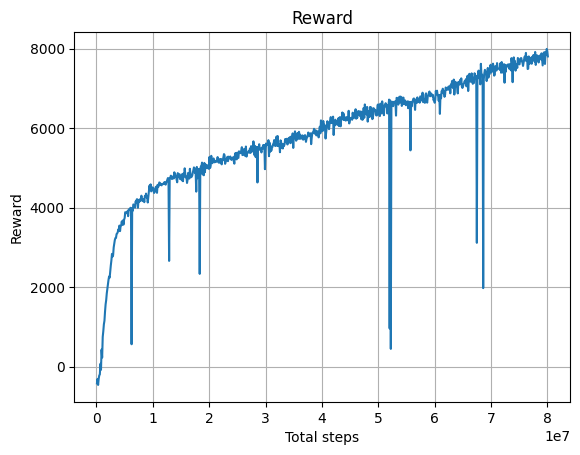

100%|█████████████████████████████████████████████████████████████████| 250000/250000 [2:20:49<00:00, 29.59it/s]


In [178]:
steps = []
rewards = []

for i in tqdm(range(n_iter)):
    trajectory = sampler.get_next()

    if (i + 1) % 100 == 0:
        clear_output(True)
        rewards.append(vec_env.env.env.env.return_queue[-1])
        steps.append(sampler.runner.step_var)
        
        plt.plot(steps, rewards, label="episode rewards")
        plt.title("Reward")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()
        plt.show()

    ppo.step(trajectory)
    sched.step()

In [179]:
evaluate_model_without_rendering(
    policy=policy,
    env_id="HalfCheetah-v5",
    vec_env_normalizer=vec_env.env.env.obs_rms,
    num_episodes=5,
    max_steps=1000
)

Оценка модели на 5 эпизодах:
Средняя награда: 7736.40 ± 100.46


# Рекуррентный вариант получился лучше по средней награде за то же количество итерраций обучения